## Exploratory Data Analysis of Canadian Bill Data (1994 - 2022)

In [129]:
# Import Python libraries
import pandas as pd
import numpy as np
import plotly.express as px

In [130]:
# Read aggregated datasets
data = pd.read_csv('../data/cleaned/bill_data.csv')
parliaments = pd.read_csv('../data/cleaned/parliament_data.csv')

# Change parliaments columns back to datetime format
for col in ['StartDate', 'EndDate']:
    parliaments[col] = pd.to_datetime(parliaments[col])

parliaments['Duration'] = pd.to_timedelta(parliaments['Duration'])

# Display all columns
with pd.option_context('display.max_columns', None): 
    display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days


Visualization Ideas:
1. Number of bills in each parliament (do parliaments have consistent length?)
2. Number and percentage of bills by type
3. Number of bills that made it to each stage (bar chart)
4. Mean, median, and outliers of the time spent debating (amongst bills that received royal assent)
5. Number of bills sponsored by political affiliation (take a subset of years as well, compare Harper and Trudeau eras)
6. Group the bills by title if possible

Out of Curiosity:
- Which person sponsored the greatest number of bills, also sort by role (Senator, MP, other?)
- Which constituency sponsored the greatest number of bills

### Part 1: Bills by Parliament Number

In [131]:
# Number of bills in each parliament
data_1 = data[[
    'ParliamentNumber',
    'SessionNumber',
    'ReceivedRoyalAssent', 
    'ReadingsPassed'
]].groupby([
    'ParliamentNumber',
    'SessionNumber'
])

data_1 = pd.concat([
    data_1.sum(), 
    data_1.size()], 
    axis = 1
)

data_1.rename(columns = {
    'ReceivedRoyalAssent': 'BillsPassed',
    'ReadingsPassed': 'TotalReadingsPassed',
    0: 'UniqueBills'
}, inplace = True)

data_1.reset_index(inplace = True)

display(data_1.head(4))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills
0,35,1,101,845,300
1,35,2,69,755,358
2,36,1,86,907,438
3,36,2,38,625,390


In [132]:
# Merge with parliament data
data_1 = pd.merge(data_1, parliaments, on = ['ParliamentNumber', 'SessionNumber'], how = 'left')

print(data_1.dtypes)
display(data_1.head(4))

ParliamentNumber                 int64
SessionNumber                    int64
BillsPassed                      int64
TotalReadingsPassed              int64
UniqueBills                      int64
Party                           object
PrimeMinister                   object
Minority                          bool
StartDate               datetime64[ns]
EndDate                 datetime64[ns]
Duration               timedelta64[ns]
SenateSittings                 float64
HouseSittings                    int64
dtype: object


,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings
0,35,1,101,845,300,Liberal Party,Jean Chrétien,False,1994-01-17,1996-02-02,746 days,133.0,278
1,35,2,69,755,358,Liberal Party,Jean Chrétien,False,1996-02-27,1997-04-27,425 days,96.0,164
2,36,1,86,907,438,Liberal Party,Jean Chrétien,False,1997-09-22,1999-09-18,726 days,158.0,243
3,36,2,38,625,390,Liberal Party,Jean Chrétien,False,1999-10-12,2000-10-22,376 days,84.0,133


In [133]:
# Create readings per day and bills per day columns
data_1['ReadingsPerDay'] = data_1['TotalReadingsPassed'] / data_1['Duration'].dt.days
data_1['BillsPerDay'] = data_1['BillsPassed'] / data_1['Duration'].dt.days

display(data_1.head(3))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay
0,35,1,101,845,300,Liberal Party,Jean Chrétien,False,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389
1,35,2,69,755,358,Liberal Party,Jean Chrétien,False,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353
2,36,1,86,907,438,Liberal Party,Jean Chrétien,False,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457


In [134]:
# Removing sessions lasting less than 150 days due to the unstable nature of these parliaments

data_1 = data_1.loc[data_1['Duration'].dt.days > 150, :]

# Create new column that aggregates party and minority status

data_1['Party'] = data_1['Party'].apply(lambda x: x.split(' ', 1)[0])
data_1['Minority'] = data_1['Minority'].apply(lambda x: 'Minority' if x == True else 'Majority')
data_1['Government'] = data_1['Party'] + ' ' + data_1['Minority']

# Create middle date column

data_1['StartYear'] = pd.DatetimeIndex(data_1['StartDate']).year.astype(str)
data_1 = data_1.reset_index()

display(data_1.head(3))

,index,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay,Government,StartYear
0,0,35,1,101,845,300,Liberal,Jean Chrétien,Majority,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389,Liberal Majority,1994
1,1,35,2,69,755,358,Liberal,Jean Chrétien,Majority,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353,Liberal Majority,1996
2,2,36,1,86,907,438,Liberal,Jean Chrétien,Majority,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457,Liberal Majority,1997


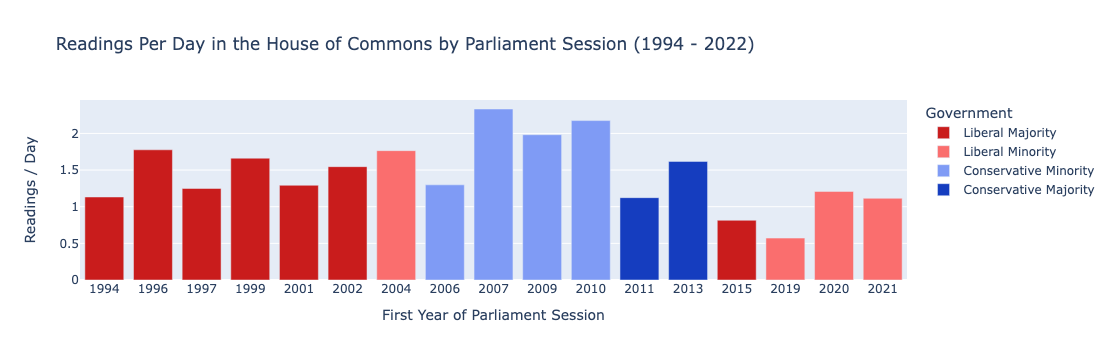

In [135]:
color_map =  { 
    "Liberal Majority": "#c91c1c", 
    "Liberal Minority": "#fa6e6e",
    "Conservative Minority": "#7f9bf5",
    "Conservative Majority": "#153dbf"
}

fig = px.bar(
    data_1, 
    x = "StartYear", 
    y = "ReadingsPerDay", 
    color= "Government",
    color_discrete_map = color_map,
    title = "Readings Per Day in the House of Commons by Parliament Session (1994 - 2022)",
    labels = {
        "StartYear": "First Year of Parliament Session",
        "ReadingsPerDay": "Readings / Day"
    }
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

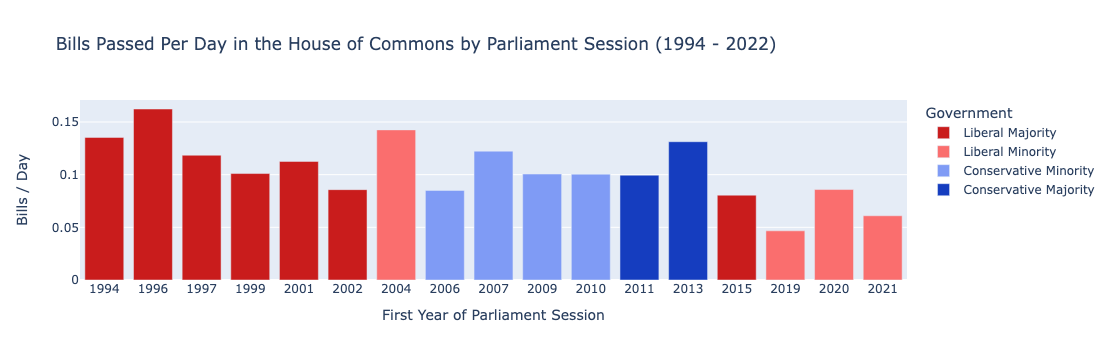

In [136]:
fig = px.bar(
    data_1, 
    x = "StartYear", 
    y = "BillsPerDay", 
    color="Government",
    color_discrete_map = color_map,
    title = "Bills Passed Per Day in the House of Commons by Parliament Session (1994 - 2022)",
    labels = {
        "StartYear": "First Year of Parliament Session",
        "BillsPerDay": "Bills / Day"
    }
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

### Part 2: Bills By Type and Origin

In [137]:
data_2 = pd.DataFrame(data['BillType'].value_counts())
data_2.reset_index(inplace = True)

data_2.rename(
    columns = {
        "index": "Bill Type",
        "BillType": "Count"
    }, 
    inplace = True
)

def getOrigin(x):
    x = x.split(' ')[0]
    return x

data_2["Origin"] = data_2["Bill Type"].apply(lambda x: getOrigin(x))

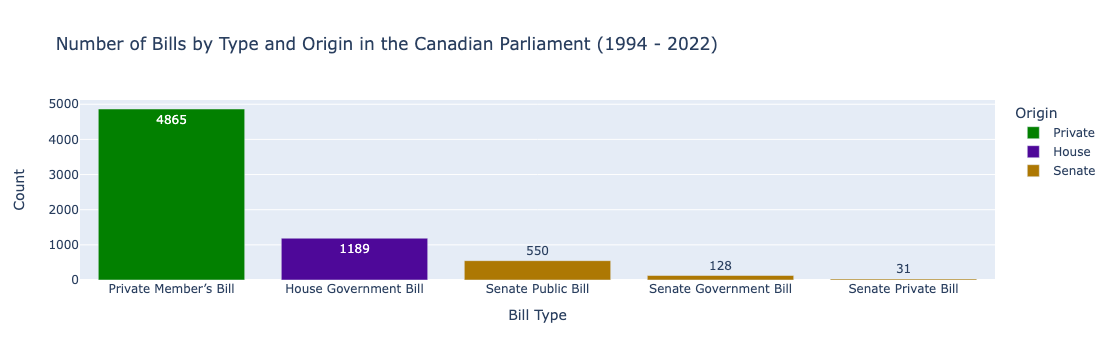

In [140]:
color_map = {
    "Private": "#028000",
    "House": "#4e0899",
    "Senate": "#ad7803"
}

fig = px.bar(
    data_2, 
    x = "Bill Type",
    y = "Count",
    text = "Count",
    color = "Origin",
    color_discrete_map = color_map,
    title = "Number of Bills by Type and Origin in the Canadian Parliament (1994 - 2022)"
)

fig.show()